# E01 Low-level audio classification

### Gianluca Scuri 886725

Implement the Zero-Crossing Rate (ZCR) feature to describe a single-channel audio signal, starting from the commands shown during the laboratory.

1. Show the effects on classification performance for the dataset "free-spoken-digit-dataset" (recordings.tar).
2. Verify the effect of using ZCR alone and in combination with other features available in the published notebook.
3. Using libraries such as Librosa is not allowed, as they offer pre-made functions to compute ZCR.
4. It is, instead, possible to use numpy for the basic operations (shift, sign, etc.).
5. Many variations of ZCR exist and will be accepted: whenever you make arbitrary decisions in the implementation, just describe them in the submission.

In [ ]:
# Import packages
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
import tarfile
from shutil import copyfile

In [ ]:
drive.mount('/content/gdrive')
tar = tarfile.open('gdrive/MyDrive/Colab Notebooks/Digital Signal/Datasets/recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Example

In [ ]:
[sound_rate, sound_data] = wav.read('recordings/0_jackson_0.wav')
print(sound_rate)
print(sound_data.shape)

8000
(5148,)


In [ ]:
ipd.Audio(sound_data, rate=sound_rate)

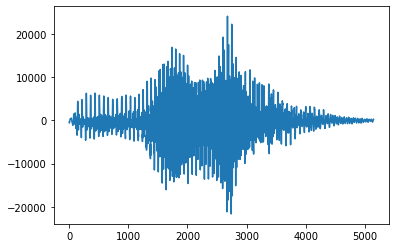

In [ ]:
from matplotlib import pyplot as plt
plt.plot(sound_data)

## Data loader

In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

## SVM con ZCR

### Feature extractor

In [ ]:
# Feature extractor (Zero Crossing Rate)
def zcr(input):
  input = input[input != 0]
  count = np.sum(np.diff(np.sign(input)) != 0)
  return np.array([count])

Calcolo del numero di Zero Crossing

1. rimozione degli zeri per evitare una sottostima nel numero di attraversamenti
2. utilizzo della funzione sign per trasformare i numeri in {1, -1} in base al segno, differenza tra coppie contigue di valori con la funzione diff, calcolo del numero dei risultati diversi da 0
3. trasformazione dello scalare in un array di numpy

### Fitting

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr, normalize=False)

In [ ]:
print(len(X_train))
print(len(X_test))

1350
150


In [ ]:
print(X_train[0]) # zcr della prima traccia
print(y_train[0]) # label della prima traccia

[523]
4


In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 4.424s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.005


In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.29      0.36        17
           1       0.12      0.40      0.19        10
           2       0.09      0.07      0.08        15
           3       0.33      0.21      0.26        19
           4       0.08      0.09      0.09        11
           5       0.20      0.29      0.24        14
           6       0.64      0.64      0.64        14
           7       0.09      0.05      0.07        19
           8       0.23      0.18      0.20        17
           9       0.23      0.21      0.22        14

    accuracy                           0.23       150
   macro avg       0.25      0.24      0.23       150
weighted avg       0.25      0.23      0.23       150



Confusion matrix:


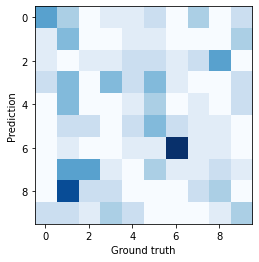

In [ ]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

Il risultato é un modello con una accuratezza del 23% e una matrice di confusione con una diagonale poco definita, l'unico numero ad essere correttamente classificato é il 6.

## SVM con ZCR + energia + durata

### Feature extractor

In [ ]:
def energy(input):
  return np.sum((input*1.0)**2, keepdims=True)

def duration(input):
  return np.array(input.shape)

In [ ]:
def combo(input):
  return np.concatenate((zcr(input), energy(input), duration(input)))

### Fitting

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 3.446s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.5


In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.53      0.60        17
           1       0.35      0.80      0.48        10
           2       0.57      0.53      0.55        15
           3       0.78      0.37      0.50        19
           4       0.43      0.55      0.48        11
           5       0.41      0.50      0.45        14
           6       0.83      0.71      0.77        14
           7       0.60      0.32      0.41        19
           8       0.50      0.59      0.54        17
           9       0.56      0.71      0.63        14

    accuracy                           0.54       150
   macro avg       0.57      0.56      0.54       150
weighted avg       0.59      0.54      0.54       150



Confusion matrix:


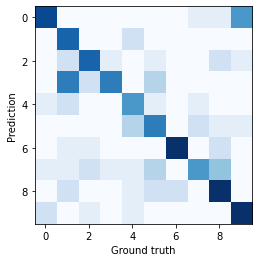

In [ ]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

La classificazione con energia + durata fornisce un'accuratezza del 33% mentre con l'aggiunta dello ZCR l'accuratezza é passata al 54% e la matrice presenta una diagonale molto piú marcata indicando una migliore classificazione.